In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
from sklearn.model_selection import KFold 
from sklearn.preprocessing import OneHotEncoder
import random
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.grid_search import GridSearchCV # perform grid search

### Data Loading

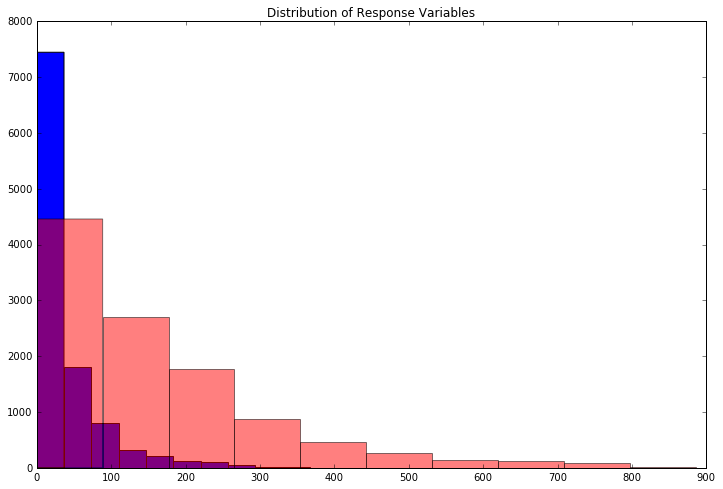

In [2]:
train_df = pd.read_csv("train.csv", header=0)
test_df = pd.read_csv("test.csv", header = 0)
# distribution of response variables
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
plt.hist(train_df["casual"])
plt.hist(train_df["registered"], color="red", alpha=0.5)
plt.title("Distribution of Response Variables")
plt.show()

###  Feature Engineer

#### split datetime

In [3]:
# convert datetime column in training data into multiple columns (year/month/day/hour/weekday)
dt = pd.to_datetime(train_df["datetime"]) # convert string to datetime type
train_df["year"] = dt.map(lambda x: x.year) 
train_df["month"] = dt.map(lambda x: x.month)
train_df["day"] = dt.map(lambda x: x.day)
train_df["hour"] = dt.map(lambda x: x.hour)
train_df["weekday"] = dt.map(lambda x: x.weekday())
print train_df.shape, train_df.columns

(10886, 17) Index([u'datetime', u'season', u'holiday', u'workingday', u'weather', u'temp',
       u'atemp', u'humidity', u'windspeed', u'casual', u'registered', u'count',
       u'year', u'month', u'day', u'hour', u'weekday'],
      dtype='object')


#### One-hot-encoding for categorical variables

In [4]:
categorical = ['season','holiday','workingday','weather'] # categorical features
encode_feature = train_df[categorical].values
enc = OneHotEncoder()
encode_result = enc.fit_transform(encode_feature).toarray()
print "encoded results for the categorical features: ", "\n"
print encode_result, np.shape(encode_result), "\n"

features = train_df.drop(categorical, axis=1) # drop original categorical features
features = features.drop(["datetime", "temp", "casual", "registered","count"], axis=1) # drop datetime and temp and response variable
print features.shape, "\n"

after_encode = np.concatenate([encode_result,features.values], axis = 1)
print "combine encoded features with other numerical features: ", "\n"
print after_encode, np.shape(after_encode), "\n"

encoded results for the categorical features:  

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]] (10886, 12) 

(10886, 8) 

combine encoded features with other numerical features:  

[[  1.   0.   0. ...,   1.   0.   5.]
 [  1.   0.   0. ...,   1.   1.   5.]
 [  1.   0.   0. ...,   1.   2.   5.]
 ..., 
 [  0.   0.   0. ...,  19.  21.   2.]
 [  0.   0.   0. ...,  19.  22.   2.]
 [  0.   0.   0. ...,  19.  23.   2.]] (10886, 20) 



### Evaluation

In [5]:
# Evaluation
def cal_rmlse(pred, actual):
    """
    evaluation of model
    parameters:
    -----------
    pred: array or list
        prediction
    actual: array or list
        actual target value
    return:
    -----------
    rmlse
    """
    rmlse = np.sqrt(np.mean((np.log(np.array(pred) + 1)- np.log(np.array(actual) + 1))**2))
    return rmlse
# test example
cal_rmlse([1,2,3],[2,6,2])

0.56717915832655263

### Predictive Models  

#### General Linear Regression Model

In [6]:
kf = KFold(n_splits=10)
exog = sm.add_constant(after_encode)
casual_pred_rmlse = []
reg_pred_rmlse = [] 
for train_index, test_index in kf.split(exog):
    glm_pois = sm.GLM(train_df.loc[train_index, "casual"], exog[train_index, :], family=sm.families.Poisson()).fit()
    casual_rmlse = cal_rmlse(actual=train_df.loc[test_index, "casual"], \
                             pred=glm_pois.predict(exog[test_index, :]))
    print "casual rmlse:", casual_rmlse
    casual_pred_rmlse.append(casual_rmlse)
    glm_pois = sm.GLM(train_df.loc[train_index, "registered"], exog[train_index, :], family=sm.families.Poisson()).fit()
    reg_rmlse = cal_rmlse(actual=train_df.loc[test_index, "registered"], \
                         pred=glm_pois.predict(exog[test_index, :]))
    print "registered rmlse:", reg_rmlse
    reg_pred_rmlse.append(reg_rmlse)    

casual rmlse: 1.20350551025
registered rmlse: 1.30017009715
casual rmlse: 1.0040910638
registered rmlse: 1.18650908777
casual rmlse: 1.02661640316
registered rmlse: 1.12415979082
casual rmlse: 0.922772722983
registered rmlse: 1.12956546575
casual rmlse: 1.20036156458
registered rmlse: 1.18589871478
casual rmlse: 2.57066037023
registered rmlse: 3.69847210198
casual rmlse: 1.08835709623
registered rmlse: 1.25539668798
casual rmlse: 1.2417827738
registered rmlse: 1.19750928929
casual rmlse: 1.04478881104
registered rmlse: 1.15721631423
casual rmlse: 1.12741500932
registered rmlse: 1.26524485528


In [7]:
print "RMLSE of Casual Users:", np.mean(casual_pred_rmlse)
print "RMLSE of Registered Users:", np.mean(reg_pred_rmlse)

RMLSE of Casual Users: 1.24303513254
RMLSE of Registered Users: 1.4500142405


#### Generalized Linear Regression - without one-hot-encoding data

In [8]:
without_encode = train_df.drop(["datetime", "casual", "registered", "count"], axis=1)
kf = KFold(n_splits=10)
exog = sm.add_constant(without_encode.values)
casual_pred_rmlse = []
reg_pred_rmlse = [] 
for train_index, test_index in kf.split(exog):
    glm_pois = sm.GLM(train_df.loc[train_index, "casual"], exog[train_index, :], family=sm.families.Poisson()).fit()
    casual_rmlse = cal_rmlse(actual=train_df.loc[test_index, "casual"], \
                             pred=glm_pois.predict(exog[test_index, :]))
    print "casual rmlse:", casual_rmlse
    casual_pred_rmlse.append(casual_rmlse)
    glm_pois = sm.GLM(train_df.loc[train_index, "registered"], exog[train_index, :], family=sm.families.Poisson()).fit()
    reg_rmlse = cal_rmlse(actual=train_df.loc[test_index, "registered"], \
                         pred=glm_pois.predict(exog[test_index, :]))
    print "registered rmlse:", reg_rmlse
    reg_pred_rmlse.append(reg_rmlse)   

casual rmlse: 1.32727042654
registered rmlse: 1.33145620271
casual rmlse: 1.03317700649
registered rmlse: 1.18824084911
casual rmlse: 0.958023458605
registered rmlse: 1.12156037762
casual rmlse: 0.976019370481
registered rmlse: 1.16737754119
casual rmlse: 1.16737729285
registered rmlse: 1.17492832321
casual rmlse: 1.34596349267
registered rmlse: 1.28043596875
casual rmlse: 1.0754801433
registered rmlse: 1.23686858647
casual rmlse: 1.26446235875
registered rmlse: 1.20905200935
casual rmlse: 1.11143275035
registered rmlse: 1.19522882965
casual rmlse: 1.08571526492
registered rmlse: 1.23585822512


In [9]:
print "RMLSE of Casual Users:", np.mean(casual_pred_rmlse)
print "RMLSE of Registered Users:", np.mean(reg_pred_rmlse)

RMLSE of Casual Users: 1.1344921565
RMLSE of Registered Users: 1.21410069132


#### visualization - without one-hot-encode data

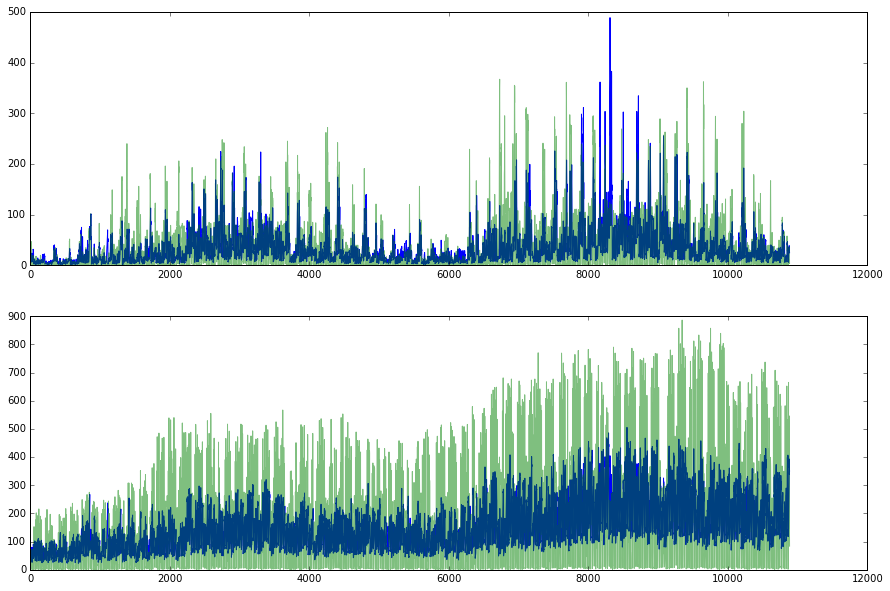

In [10]:
exog = sm.add_constant(without_encode)
glm_pois = sm.GLM(train_df["casual"], exog, family=sm.families.Poisson()).fit()
casual_pred = glm_pois.predict()
glm_pois = sm.GLM(train_df["registered"], exog, family=sm.families.Poisson()).fit()
registered_pred = glm_pois.predict()
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
plt.plot(casual_pred)
plt.plot(train_df["casual"], alpha=0.5)
ax2 = fig.add_subplot(212)
plt.plot(registered_pred)
plt.plot(train_df["registered"], alpha=0.5)
plt.show()

#### Random Forests

In [11]:
# random forest with one-hot-encode data
rf = RandomForestRegressor(n_estimators=200, max_depth=5)
kf = KFold(n_splits=10)
casual_pred_rmlse = []
register_pred_rmlse = []
for train_index, test_index in kf.split(after_encode):
    rf.fit(after_encode[train_index, :], train_df.loc[train_index, "casual"])
    casual_rmlse = cal_rmlse(actual=train_df.loc[test_index,"casual"], \
                             pred= rf.predict(after_encode[test_index,:]))
    print "casual rmlse:", casual_rmlse
    casual_pred_rmlse.append(casual_rmlse)
    rf.fit(after_encode[train_index,:], train_df.loc[train_index, "registered"])
    register_rmlse = cal_rmlse(actual=train_df.loc[test_index, "registered"],\
                               pred=rf.predict(after_encode[test_index, :]))
    print "registered rmlse:", register_rmlse
    register_pred_rmlse.append(register_rmlse)    

casual rmlse: 1.39993494664
registered rmlse: 1.12372707897
casual rmlse: 0.848288678568
registered rmlse: 0.68551722645
casual rmlse: 0.609647419814
registered rmlse: 0.481330013058
casual rmlse: 0.74778167053
registered rmlse: 0.582340133097
casual rmlse: 0.873342862865
registered rmlse: 0.615706887864
casual rmlse: 1.2054408375
registered rmlse: 0.821363830139
casual rmlse: 0.757511071255
registered rmlse: 0.522674584335
casual rmlse: 0.621190284521
registered rmlse: 0.496405561127
casual rmlse: 0.6603667334
registered rmlse: 0.509861788882
casual rmlse: 0.742599844771
registered rmlse: 0.494754532061


In [12]:
print "RMLSE of Casual Users:", np.mean(casual_pred_rmlse)
print "RMLSE of Registered Users:", np.mean(register_pred_rmlse)

RMLSE of Casual Users: 0.846610434986
RMLSE of Registered Users: 0.633368163599


In [13]:
# random forest without one-hot-encode data
rf = RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=30)
kf = KFold(n_splits=10)
casual_pred_rmlse = []
register_pred_rmlse = []
for train_index, test_index in kf.split(without_encode):
    rf.fit(without_encode.values[train_index, :], train_df.loc[train_index, "casual"])
    casual_rmlse = cal_rmlse(actual=train_df.loc[test_index,"casual"], \
                             pred= rf.predict(without_encode.values[test_index,:]))
    print "casual rmlse:", casual_rmlse
    casual_pred_rmlse.append(casual_rmlse)
    rf.fit(without_encode.values[train_index,:], train_df.loc[train_index, "registered"])
    register_rmlse = cal_rmlse(actual=train_df.loc[test_index, "registered"],\
                               pred=rf.predict(without_encode.values[test_index, :]))
    print "registered rmlse:", register_rmlse
    register_pred_rmlse.append(register_rmlse)    

casual rmlse: 0.968492902684
registered rmlse: 0.850019501955
casual rmlse: 0.729550210947
registered rmlse: 0.534029464762
casual rmlse: 0.487194750446
registered rmlse: 0.323990766578
casual rmlse: 0.599791084382
registered rmlse: 0.43177178963
casual rmlse: 0.722162746228
registered rmlse: 0.462216002129
casual rmlse: 0.997812480899
registered rmlse: 0.637694446956
casual rmlse: 0.617465185021
registered rmlse: 0.412258088894
casual rmlse: 0.498828144547
registered rmlse: 0.327783613224
casual rmlse: 0.513411028829
registered rmlse: 0.344009311609
casual rmlse: 0.600308462234
registered rmlse: 0.382277497829


In [14]:
print "RMLSE of Casual Users:", np.mean(casual_pred_rmlse)
print "RMLSE of Registered Users:", np.mean(register_pred_rmlse)

RMLSE of Casual Users: 0.673501699622
RMLSE of Registered Users: 0.470605048356


In [15]:
rf = RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=30).fit(without_encode.values, train_df["casual"])
casual_pred = rf.predict(without_encode.values)
rf = RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=30).fit(without_encode.values, train_df["registered"])
register_pred = rf.predict(without_encode.values)

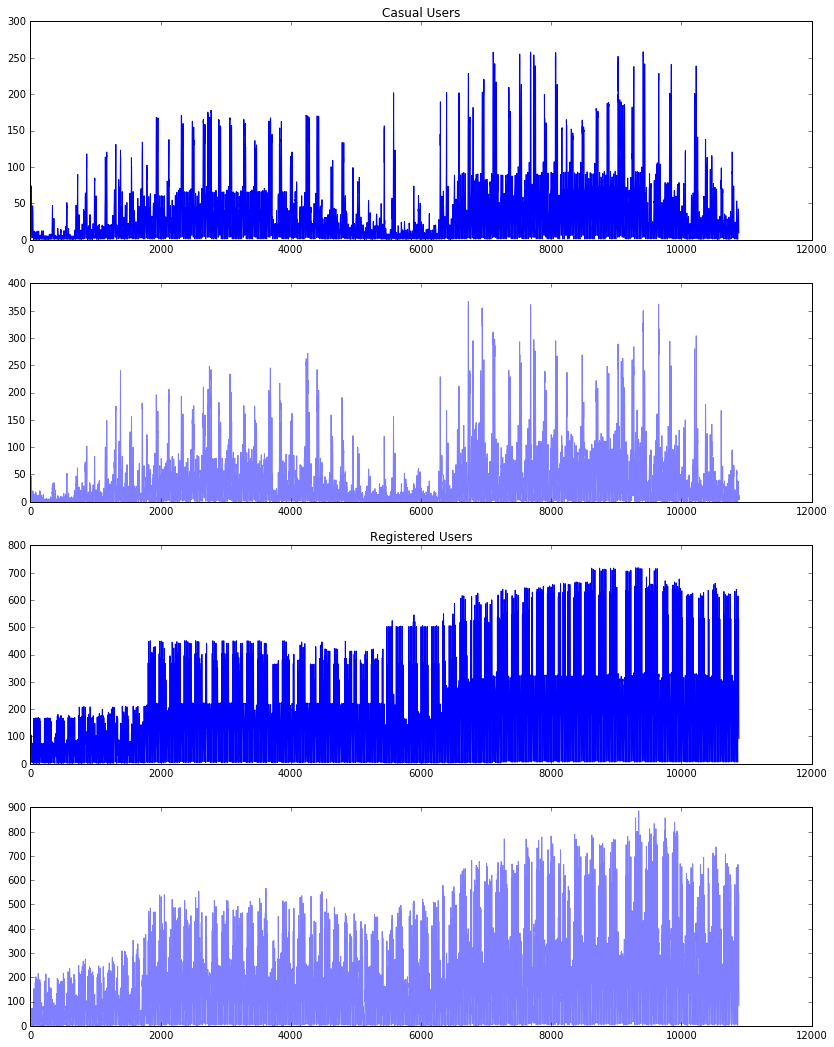

In [16]:
# train_df["casual"].plot.kde()
# pd.Series(casual_pred).plot.kde()
fig = plt.figure(figsize=(14,18))
ax1 = fig.add_subplot(411)
plt.plot(casual_pred)
plt.title("Casual Users")
ax2 = fig.add_subplot(412)
plt.plot(train_df["casual"], alpha=0.5)
ax3 = fig.add_subplot(413)
plt.plot(register_pred)
plt.title("Registered Users")
ax4 = fig.add_subplot(414)
plt.plot(train_df["registered"], alpha=0.5)
plt.show()

### Prediction of Test Data

In [45]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_dt= pd.to_datetime(train_df["datetime"])
test_dt = pd.to_datetime(test_df["datetime"])
train_df["year"] = train_dt.map(lambda x: x.year) 
train_df["month"] = train_dt.map(lambda x: x.month)
train_df["day"] = train_dt.map(lambda x: x.day)
train_df["hour"] = train_dt.map(lambda x: x.hour)
train_df["weekday"] = train_dt.map(lambda x: x.weekday())
test_df["year"] = test_dt.map(lambda x: x.year) 
test_df["month"] = test_dt.map(lambda x: x.month)
test_df["day"] = test_dt.map(lambda x: x.day)
test_df["hour"] = test_dt.map(lambda x: x.hour)
test_df["weekday"] = test_dt.map(lambda x: x.weekday())

train_df.set_index(["datetime"], inplace=True)
test_df.set_index(["datetime"], inplace=True)
print train_df.head(), train_df.shape
print test_df.head(), test_df.shape

                     season  holiday  workingday  weather  temp   atemp  \
datetime                                                                  
2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

                     humidity  windspeed  casual  registered  count  year  \
datetime                                                                    
2011-01-01 00:00:00        81        0.0       3          13     16  2011   
2011-01-01 01:00:00        80        0.0       8          32     40  2011   
2011-01-01 02:00:00        80        0.0       5          27     32  2011   
2011-01-01 03:00:00        75        0.0       3          10     13  2011   
2011-01-01 0

In [46]:
train_df.set_index(["datetime"], inplace=True)
test_df.set_index(["datetime"], inplace=True)
print train_df.head(), train_df.shape
print test_df.head(), test_df.shape

KeyError: 'datetime'

In [47]:
train_df_features = train_df.drop(["casual", "registered", "count"], axis=1)
year = ["2011", "2012"]
month = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13"]
casual = []
register = []
for yr in year:
    for idx in range(len(month)-1):
        start = yr + "-" + month[idx]
        end = yr + "-" + month[idx+1]
        rf = RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=30).fit(train_df_features[:end].values, train_df[:end]["casual"])
        casual_pred = rf.predict(test_df[start:end].values)
        casual.append(casual_pred)
        rf = RandomForestRegressor(n_estimators=500, max_depth=9, min_samples_leaf=30).fit(train_df_features[:end].values, train_df[:end]["registered"])
        register_pred = rf.predict(test_df[start:end].values)
        register.append(register_pred)
casual_flat = [item for sublist in casual for item in sublist]
register_flat = [item for sublist in register for item in sublist]
print len(casual_flat), len(register_flat)

6493 6493


In [20]:
test_df["casual"] = [int(x) for x in casual_flat]
test_df["registered"] = [int(x) for x in register_flat]
test_df["count"] = test_df["casual"] + test_df["registered"]
test_df.reset_index(inplace=True)

In [21]:
test_df.to_csv("prediction.csv")

In [22]:
train_df.shape

(10886, 16)